<h2>Group 004 25 Project Report</h2>
<br>

<h3>Introduction</h3>

A pulsar is a rapidly rotating neutron star that emits powerful beams of light at its magnetic poles. The beam of emission rotates with the star, and it is only visible when it crosses our line of sight. When the light is pointing towards the Earth, it produces a detectable pattern of broadband radio emission. “As the pulsar rotates, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.”(Shaw, 2021). However, in practice, while trying to detect signals from pulsar stars, the radio telescopes will also receive plenty of signals caused by radio frequency interference (RFI) and noise. This makes legitimate signals hard to find. 

Our goal in this project is to build a K-nearest neighbor classifier that predicts whether a signal is from a pulsar star or caused by RFI and/or noise which are nonpulsar matters. 
<br>

After completing this project, we will be able to answer the following question: Based on the variables `excess_kurtosis_ip`, `skewness_ip`, `mean_c`, can we accurately predict whether a signal detection is from a pulsar star or nonpulsar objects?

<br>

The dataset that we will be using is named HTRU2 which describes a sample of pulsar candidates (signal detections that come from pulsar stars or RFI/noise) collected during the High Time Resolution Universe Survey. 
<br>
<br>
This dataset contains 17898 observations and the following 9 variables:

- Mean of the integrated profile.
- Standard deviation of the integrated profile.
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.
- Class
<br>

The first eight variables describe characteristics from the signal, and the Class variable is a categorical variable that contains the categories 0 (nonpulsar) and 1 (pulsar). The Class variable will be our target variable.


<h3>Methods</h3>

First, we load the libraries.

In [1]:
# Run this
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Loading the libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Now we obtain our dataset from the web using a URL.

In [3]:
# Reading data from url
url <- "https://raw.githubusercontent.com/aravic03/group-project-proposal/main/HTRU_2.csv"
pulsar_data <- read_csv(url,
                       col_names = c("mean_ip", "standard_deviation_ip", 
                                      "excess_kurtosis_ip", "skewness_ip",
                                      "mean_c", "standard_deviation_c", 
                                      "excess_kurtosis_c", "skewness_c",
                                      "is_pulsar" )) |> # Add column names to the data frame.                       
               mutate(is_pulsar = as_factor(is_pulsar)) # Convert our target variable to a factor.
pulsar_data
print("Table 1: Pulsar/Nonpulsar Dataset")

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_ip, standard_deviation_ip, excess_kurtosis_ip, skewness_ip, me...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,standard_deviation_ip,excess_kurtosis_ip,skewness_ip,mean_c,standard_deviation_c,excess_kurtosis_c,skewness_c,is_pulsar
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


[1] "Table 1: Pulsar/Nonpulsar Dataset"


Since we will be performing classification, we split our data into a training and a testing set.

In [4]:
set.seed(1) # set the seed

# Splitting the data into training and testing sets (60% and 40%)
pulsar_data_split <- initial_split(pulsar_data, prop = 0.6, strata = is_pulsar)
pulsar_training <- training(pulsar_data_split)
pulsar_testing <- testing(pulsar_data_split)

We will begin our preliminary data analysis process by examining the number of observations we have in the training set for each class.

In [5]:
num_obs_training <- pulsar_training |>
      group_by(is_pulsar) |>
      summarize(n = n()) |>
    mutate(percentage = 100*n/nrow(pulsar_training))
num_obs_training
print("Table 2: Distribution of Observations in the Training Set")

is_pulsar,n,percentage
<fct>,<int>,<dbl>
0,9748,90.780406
1,990,9.219594


[1] "Table 2: Distribution of Observations in the Training Set"


We can see that our data is imbalanced, and we will keep this in mind as we continue our data analysis.

Next, we will look at whether our variables contain missing values.

In [6]:
na_counts <- pulsar_training |>
     summarise_all(~ sum(is.na(.)))
na_counts

print("Table 3: The Number of Missing Values in Each Variable")

mean_ip,standard_deviation_ip,excess_kurtosis_ip,skewness_ip,mean_c,standard_deviation_c,excess_kurtosis_c,skewness_c,is_pulsar
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0


[1] "Table 3: The Number of Missing Values in Each Variable"


As shown above, there is no missing values in any of the variables. Therefore, we will move on to choosing our predictor variables.

First, we plot eight histograms, each showing the distribution of values in each of the variables excluding the `is_pulsar` variable (our target variable).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


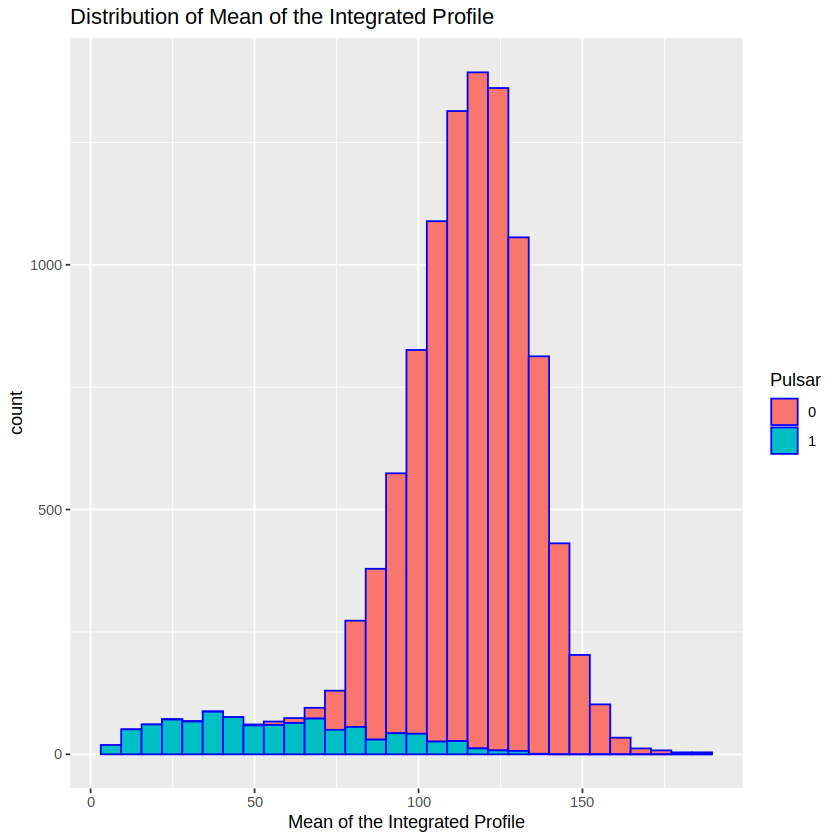

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


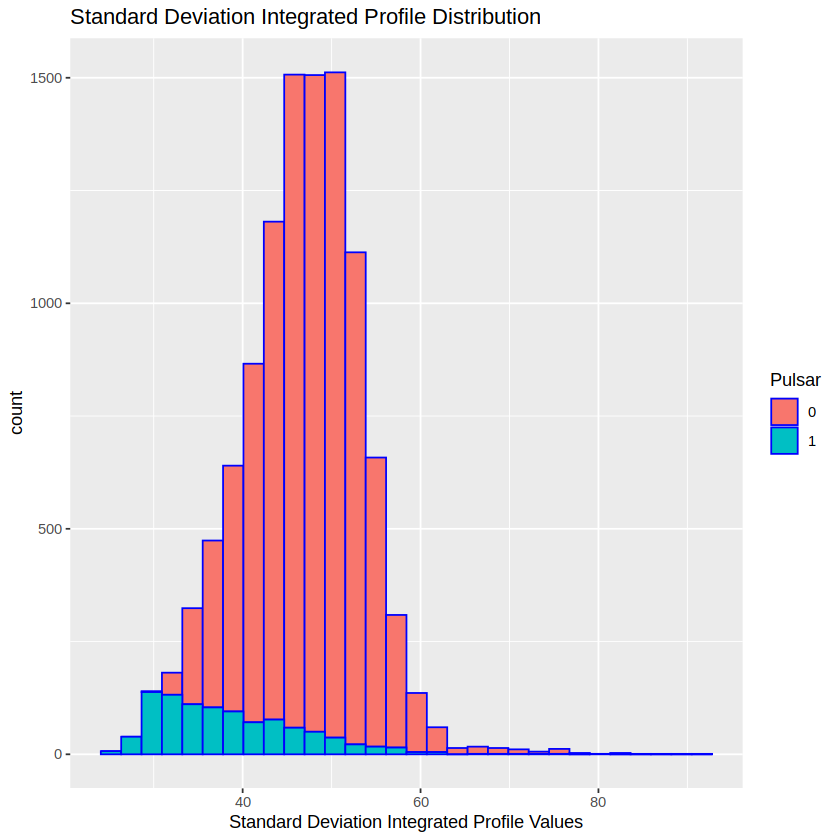

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


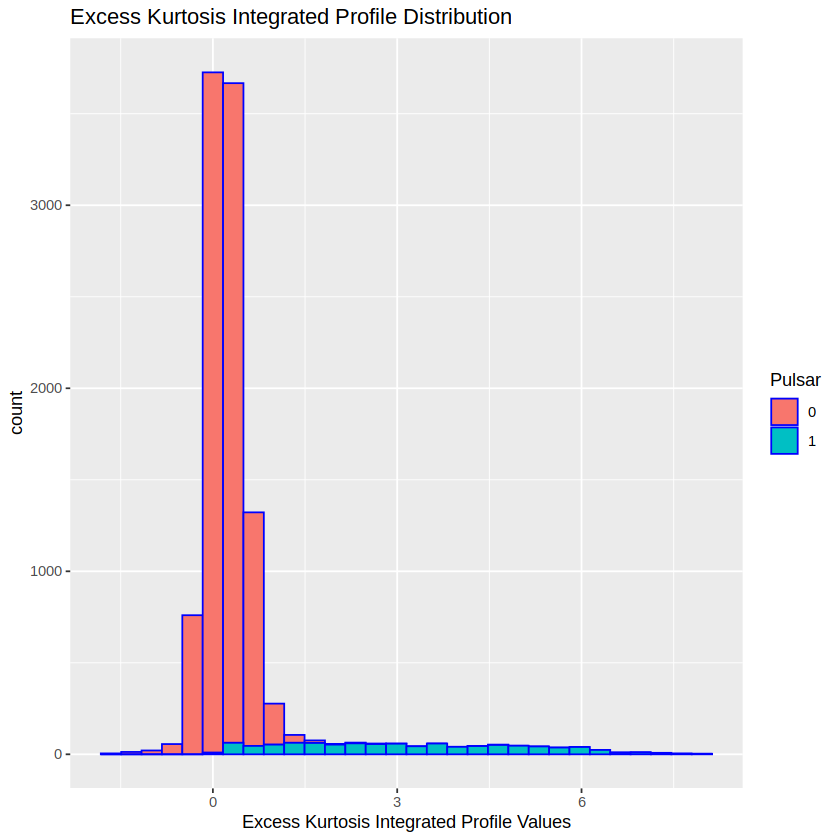

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


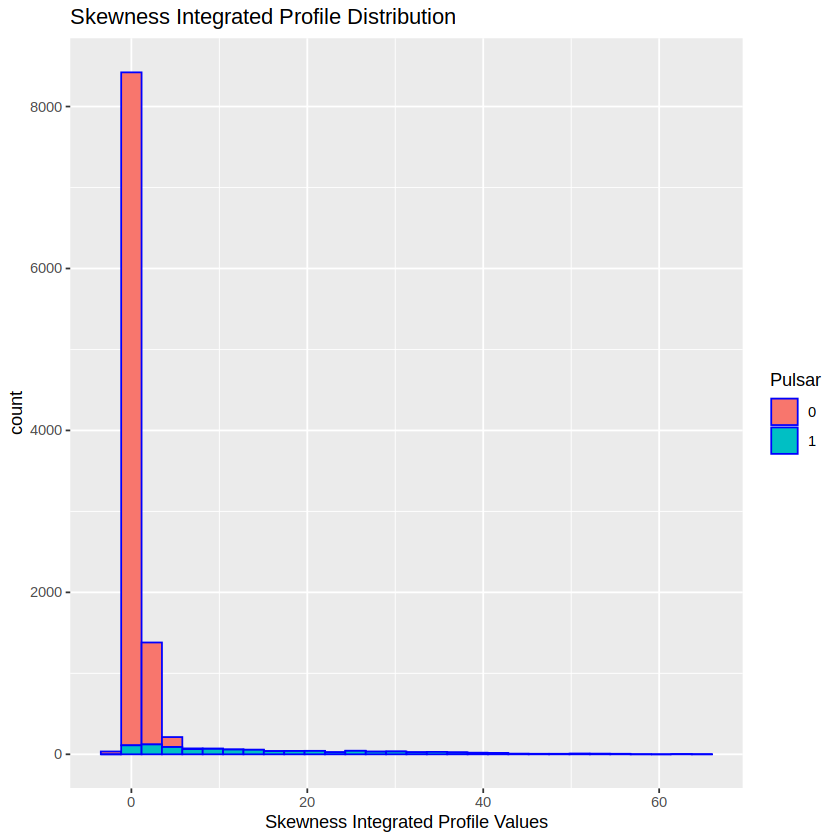

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


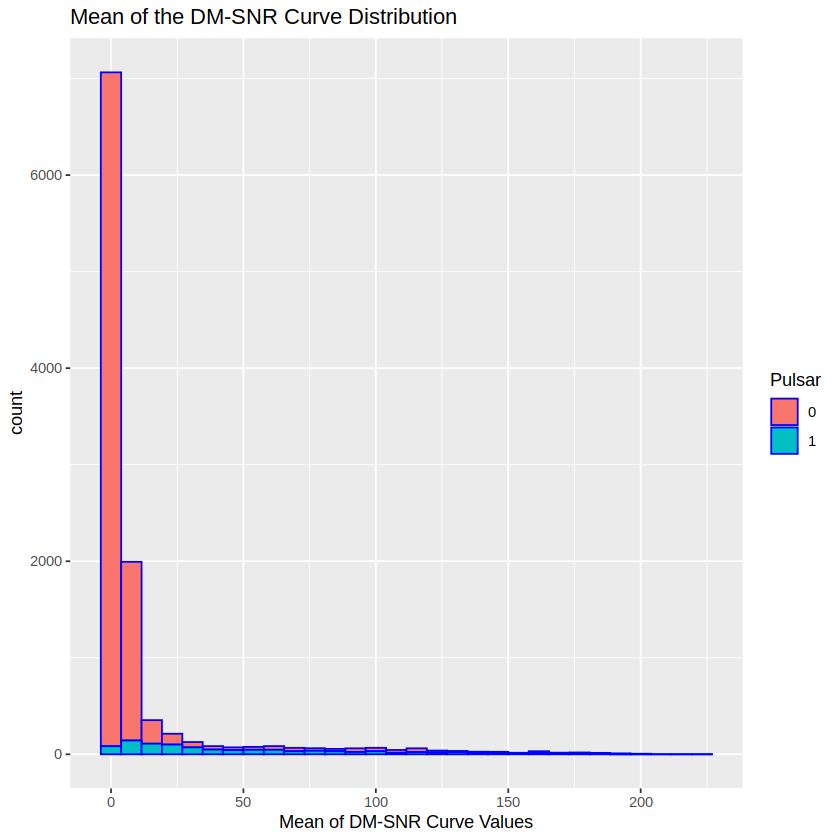

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


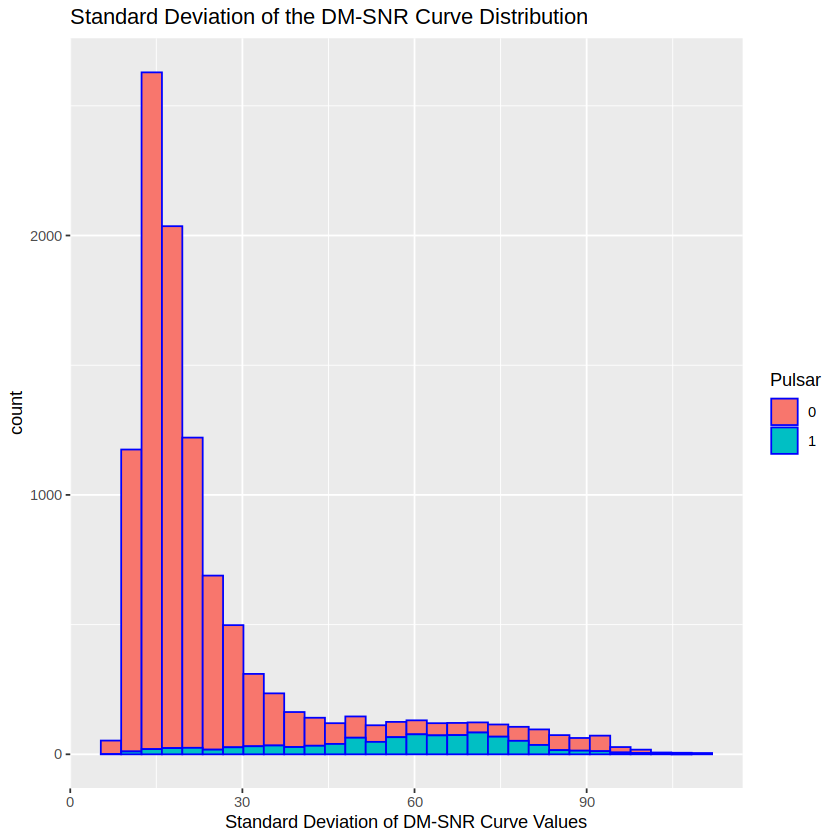

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


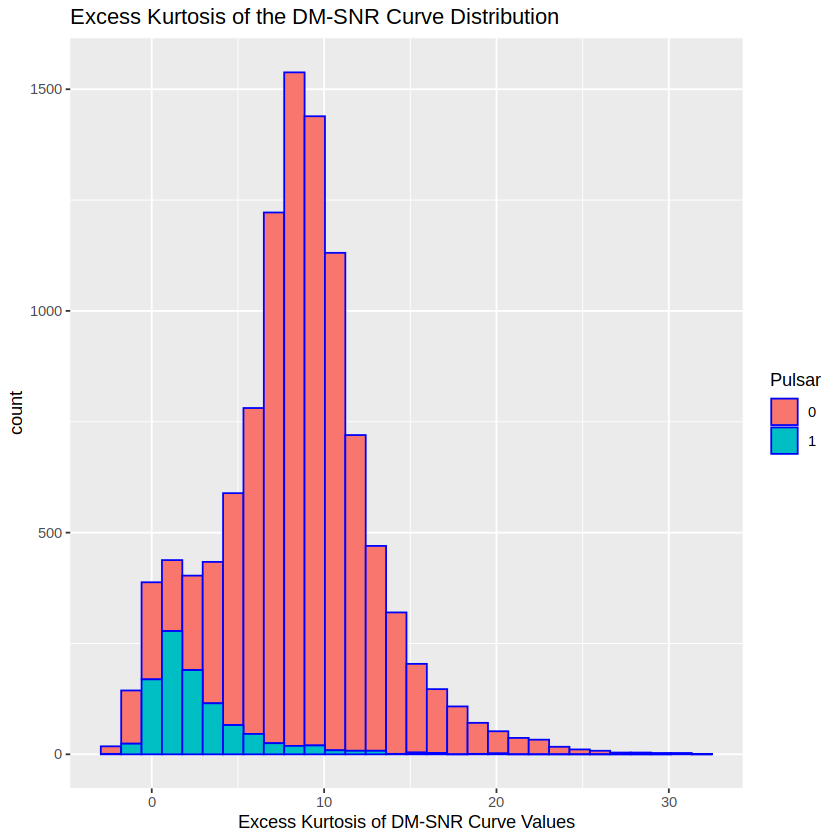

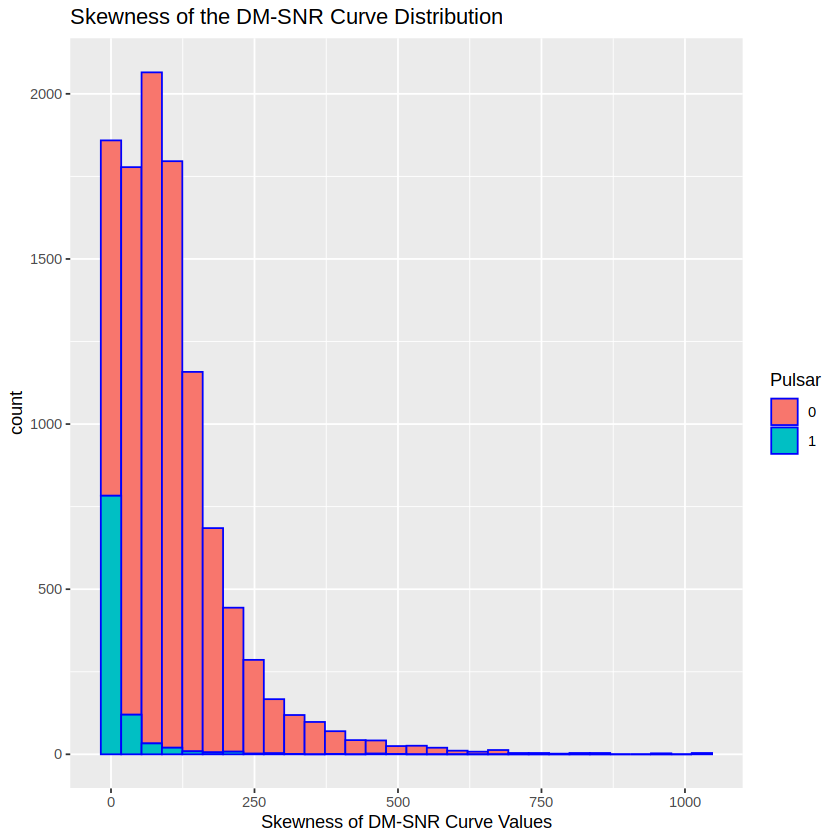

In [7]:
# Visualiizng the distribution of values in each variables using eight histograms

# Histogram 1: Distribution of the Mean of the Integrated Profile
mean_ip_plot <- ggplot(pulsar_training, aes(x = mean_ip, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Distribution of Mean of the Integrated Profile", 
       x = "Mean of the Integrated Profile", 
       fill = "Pulsar")     
mean_ip_plot

# Histogram 2: Distribution of the Standard Deviation of the Integrated Profile
sd_ip_plot <- ggplot(pulsar_training, aes(x = standard_deviation_ip, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Standard Deviation Integrated Profile Distribution", 
       x = "Standard Deviation Integrated Profile Values", 
       fill = "Pulsar")     
sd_ip_plot

# Histogram 3: Distribution of the Excess Kurtosis of the Integrated Profile
excess_kurtosis_ip_plot <- ggplot(pulsar_training, aes(x = excess_kurtosis_ip, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Excess Kurtosis Integrated Profile Distribution", x = "Excess Kurtosis Integrated Profile Values", fill = "Pulsar" )     
excess_kurtosis_ip_plot

# Histogram 4: Distribution of the Skewness of the Integrated Profile
skewness_ip_plot <- ggplot(pulsar_training, aes(x = skewness_ip, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Skewness Integrated Profile Distribution", x = "Skewness Integrated Profile Values", fill = "Pulsar" )     
skewness_ip_plot

# Histogram 5: Distribution of the Mean of DM-SNR Curve
mean_c_plot <- ggplot(pulsar_training, aes(x = mean_c, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Mean of the DM-SNR Curve Distribution", x = "Mean of DM-SNR Curve Values", fill = "Pulsar" )     
mean_c_plot

# Histogram 6: Distribution of the Standard Deviation of the DM-SNR Curve
sd_c_plot <- ggplot(pulsar_training, aes(x = standard_deviation_c, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Standard Deviation of the DM-SNR Curve Distribution", x = "Standard Deviation of DM-SNR Curve Values", fill = "Pulsar" )     
sd_c_plot

# Histogram 7: Distribution of Excess Kurtosis of DM-SNR Curve
excess_kurtosis_c_plot <- ggplot(pulsar_training, aes(x = excess_kurtosis_c, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Excess Kurtosis of the DM-SNR Curve Distribution", x = "Excess Kurtosis of DM-SNR Curve Values", fill = "Pulsar" )     
excess_kurtosis_c_plot

# Histogram 8: Skewness of the DM-SNR Curve
skewness_c_plot <- ggplot(pulsar_training, aes(x = skewness_c, fill = is_pulsar)) +
  geom_histogram(color = "blue") +
  labs(title = "Skewness of the DM-SNR Curve Distribution", x = "Skewness of DM-SNR Curve Values", fill = "Pulsar" )     
skewness_c_plot

Since we have much more nonpulsar observations than pulsar observations, there is a much higher chance that the K-nearest neighbor algorithm will classify a new observation as a nonpulsar detection. Nevertheless, a way to maintain the accuracy of our model is to choose variables where the pulsar observations have distinct values from that of the nonpulsar. Based on the histograms, we observe that for the variables `excess_kurtosis_ip`, `skewness_ip`, and `mean_c`, the values of the two classes are distinct from each other as desired. Therefore, we will choose the three variables indicated as our predictor variables. On the other hand, the nonpulsar and pulsar classes have similar range of values for the other variables, which makes those variables unfit for being our predictor variables.

Now we can begin building our K-NN classification model. 

First, we will make a recipe using our training set.

In [8]:
pulsar_recipe <- recipe(is_pulsar ~ excess_kurtosis_ip + skewness_ip + mean_c, data = pulsar_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
pulsar_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Then, we will build a tuning model for picking the best K value.

In [9]:
# tuning model
tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

tune_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we perform cross-validation, create a workflow that calculate the metrics for each of the K values 1, 6, ..., 46, and then return a data frame that shows the accuracy of each K value.

In [10]:
set.seed(123) # set the seed

# cross-validation
pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = is_pulsar)

# create a set of K values
kvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

# data analysis workflow                       
    knn_results <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(tune_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = kvals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies

print("Table 4: The accuracy estimates for each number of neighbors")

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9688952,5,0.0007000326,Preprocessor1_Model01
6,accuracy,binary,0.9785805,5,0.0007077803,Preprocessor1_Model02
11,accuracy,binary,0.9802568,5,0.0005643167,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
36,accuracy,binary,0.9795117,5,0.001188693,Preprocessor1_Model08
41,accuracy,binary,0.9786735,5,0.001067833,Preprocessor1_Model09
46,accuracy,binary,0.9783941,5,0.001049343,Preprocessor1_Model10


[1] "Table 4: The accuracy estimates for each number of neighbors"


After we have found the accuracy of our model for each K value, we create an accuracy versus K plot.

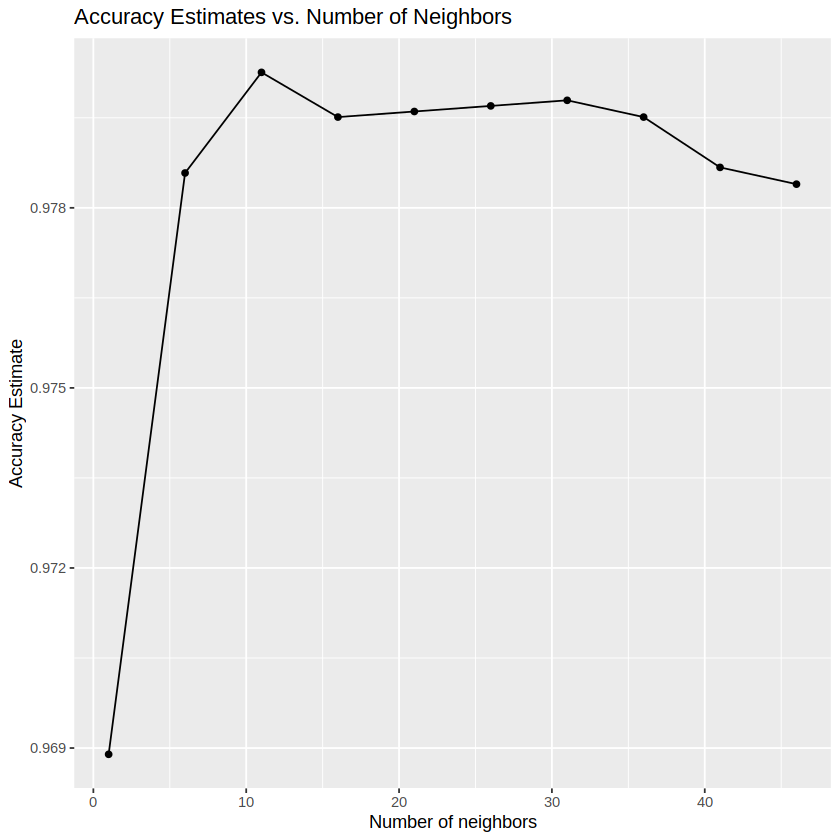

In [11]:
best_k_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy Estimates vs. Number of Neighbors")
best_k_plot

From the graph, we can see that the K value that generates the highest accuracy is about 11 (nearly an accuracy of 98%), so we will choose this number as the K for our classification model.

We will now build a new K-NN model with K = 11.

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 11
  weight_func = rectangular

Computational engine: kknn 


Then, we will use a workflow to fit our model using our training set, predict the labels in our testing set, and incorporate the predictions as the new column `.pred_class` into the testing set.

In [13]:
knn_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    fit(data = pulsar_training)

pulsar_predict <- predict(knn_fit, pulsar_testing) |>
    bind_cols(pulsar_testing)

pulsar_predict
print("Table 5: The Testing Set with an Added Column of Predicted Class")

.pred_class,mean_ip,standard_deviation_ip,excess_kurtosis_ip,skewness_ip,mean_c,standard_deviation_c,excess_kurtosis_c,skewness_c,is_pulsar
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,140.56250,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
0,102.50781,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
0,88.72656,40.67223,0.6008661,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,106.8750,47.57133,0.19944001,0.28496422,3.0794314,20.984455,8.427475,78.25937,0
0,121.3750,53.24516,0.10377221,-0.36511875,1.0953177,12.239976,16.258042,303.88002,0
0,118.4844,50.60848,-0.02905883,-0.02749376,0.4222408,8.086684,27.446113,830.63855,0


[1] "Table 5: The Testing Set with an Added Column of Predicted Class"


After having made the predictions, we will assess the accuracy of of our classifier on the testing set using the `metrics` function.

In [14]:
pulsar_accuracy <- pulsar_predict |>
    metrics(truth = is_pulsar, estimate = .pred_class) |>
    filter(.metric == "accuracy")

pulsar_accuracy
print("Table 6: The Accuracy of Predictions on Testing Set")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9789106


[1] "Table 6: The Accuracy of Predictions on Testing Set"


We can also examine the confusion matrix of our classifier's performance.

In [15]:
confusion_matrix <- pulsar_predict |>
    conf_mat(truth = is_pulsar, estimate = .pred_class)
confusion_matrix
print("Table 7: The Confusion Matrix")

          Truth
Prediction    0    1
         0 6466  106
         1   45  543

[1] "Table 7: The Confusion Matrix"


Since we are most interested in finding the class 1 (pulsar signals) observations, we will take pulsar observations as the positive observations. Using the confusion matrix above, we found that the precision of our classifier on the testing set is equal to 0.9234 and the recall is equal to 0.8367. One reason that the precision and recall are not as good as the accuracy is that our data is unbalanced. Table 2 above shows that about 91% of the observations are from class 0 (nonpulsar data) and only 9% are from class 1. Since the number of class 0 observations is overpowering, our K-NN classifier may predict an observation as 0 even if the observation has a value much closer to those observations from class 1. On the other hand, our classifier can more easily predict a class 0 observation correctly. This in turn causes the precision and recall to not be as high as the accuracy.

<h3>Discussions</h3>

<h5>Summary</h5>
We have found that using the variables `excess_kurtosis_ip`, `skewness_ip`, and `mean_c`, we can indeed build a K-NN classifier that has a fairly high accuracy (97.8%) at predicting whether an observation is from a pulsar star or a nonpulsar object. We have expected the high accuracy because the two classes have distinct distributions of values in all three variables that we chose. Nevertheless, the precision and the recall of our classifier are not as high as the accuracy due the fact that our data is imbalanced and the number of negative observations is much greater than that of the positive observations in our dataset.


<h5>Impact of a Good Classifier</h5> Pulsar stars are useful in many ways. Some pulsars have extremely precise intervals of pulses, which makes them great for measuring distances in space. Scientists can also watch the changes in a pulsar's pulses and interpret what is happening near the star. Additionally, scientists are able to identify exoplanets orbiting pulsar stars and use pulsar stars in many other purposes.
Since pulsars are such excellent cosmetic tools, a method that accurately identifies them would contribute greatly to advances in scientific discoveries.

<h5>Future Questions</h5>
Finally, we are interested in finding answers to the following questions in the future:

- How good are other types of classifiers at classifying signals from pulsar stars and nonpulsar matters?
- How do the radio signal pattern of pulsars evolve over time, and what are the factors influencing their properties?
- What is the distribution of pulsars in our galaxy and beyond?
- How do pulsars interact with their surroundings?
- Are there alternative pathways to pulsar formation, and can they be identified?

<h3>Citations</h3>

<b>The Source of our dataset</b>: Lyon, R. (n.d.). HTRU2. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/372/htru2 

Shaw, B. S. (2021, September 30). Predicting pulsar stars: An imbalanced classification task comparing Bootstrap Resampling to smote. Medium. https://towardsdatascience.com/predicting-pulsar-stars-an-imbalanced-classification-task-comparing-bootstrap-resampling-to-smote-8cfbe037b807

tanushri98. (2020, October 28). Predicting a pulsar star. Kaggle. https://www.kaggle.com/code/tanushri98/predicting-a-pulsar-star

NASA. (2017, March). Imagine the universe!. NASA. https://imagine.gsfc.nasa.gov/science/objects/neutron_stars1.html

Lea, R. (2016, April 22). What are pulsars?. Space.com. https://www.space.com/32661-pulsars.html 